In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import requests
# from astroquery import sdss
import glob

In [2]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
# df0

In [3]:
def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()
    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*100/df.size:.2f} %')

In [4]:
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

In [5]:
labels = np.unique(brightDF[21])

# access ra and dec from their columns in the dataframe
names = brightDF[1]
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.png'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'name': names,
                                 'labels': brightDF[21],
                                 'ra':ra,
                                 'dec':dec})

# brightDF_reduced = pd.DataFrame({'name': names,
#                                  'ra':ra,
#                                  'dec':dec})
# brightDF_reduced

In [6]:
# checkBalance(brightDF_reduced)
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)


# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster


# remove red contaminants
downFiles = downSampleDf1['files']
redPercent = [None]*len(downFiles)
counter = 0
workDir = 'SDSS-png/'

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(downFiles):
    testImgPath = os.path.join(workDir, x)
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
#     print(counts)
#     print(dim**2)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]
#     print(f'{filename}, {subtitle_string}')
#     if percent > 50.0:
#         counter += 1
# #         print('To be removed')
#     else:
#         pass

downSampleDf1['reds'] = redPercent # add new column of the red percentage of an image
# downSampleDf1
redList = (downSampleDf1['reds'] >= 50) # percentage threshold of how much red is in the image
# downSampleDf1.shape
df_filtered = downSampleDf1[downSampleDf1['reds'] <= 50]
# df_filtered.shape

In [7]:
df_filtered

df_filtered.to_csv('brightPCC.csv', index = False)


In [8]:
# bright_csv = 'Skyserver_CrossID8_15_2023 6_55_22 AM.csv'
bright_csv = 'Skyserver_CrossID9_1_2023 4_30_45 AM.csv'
brightDF1 = pd.read_csv(bright_csv, skiprows = 1)
brightDF1

,files,name,labels,reds,objID,ra,dec,type,u_g,modelMag_r,g_z,petroRad_r
0,sdss_ra=49.8839_dec=41.7175.png,PCC-4515,0,6.8200,1237670458048446775,49.883902,41.717491,GALAXY,2.124285,19.11043,1.930006,2.624102
1,sdss_ra=49.3925_dec=41.5647.png,PCC-0870,0,1.2650,1237661055281661796,49.392493,41.564696,GALAXY,1.545128,19.34463,1.360119,7.358008
2,sdss_ra=49.5539_dec=41.502.png,PCC-1867,0,10.2025,1237661055281662248,49.553932,41.502013,GALAXY,5.081095,19.56563,1.893360,3.664067
3,sdss_ra=49.6184_dec=41.4546.png,PCC-2341,0,1.7125,1237661055281726881,49.618438,41.454555,GALAXY,1.717859,18.95229,2.589348,2.714802
4,sdss_ra=49.5268_dec=41.3295.png,PCC-1707,0,6.0975,1237661083199145265,49.526844,41.329527,GALAXY,1.152348,18.77175,0.805294,3.169831
...,...,...,...,...,...,...,...,...,...,...,...,...
209,sdss_ra=49.9756_dec=41.3089.png,PCC-5196,1,11.9175,1237661055281856865,49.973889,41.305407,STAR,-0.215532,22.86876,3.937397,0.908567
210,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,1237670960021504409,49.994725,41.750034,GALAXY,6.157221,17.53399,1.576391,8.789475
211,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,1237661055281857031,49.996200,41.309363,STAR,1.041622,22.91631,1.991064,1.055185
212,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,1237670458048446875,49.882513,41.744532,GALAXY,3.955753,19.29449,-0.534899,7.691484


In [9]:
# '''
# df = pd.DataFrame({'A': range(1, 6),
#                    'B': range(10, 0, -2),
#                    'C C': range(10, 5, -1)})

# display(dataFrame.loc[(dataFrame['Salary']>=100000) & (dataFrame['Age']< 40) & (dataFrame['JOB'].str.startswith('D')),
#                     ['Name','JOB']])
#                    '''


In [10]:
# brightDF2 = display(brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) & (brightDF1['u_g'] < 2.5)])
brightDF2 = brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) \
                          & (brightDF1['u_g'] < 2.5) \
                          & (brightDF1['g_z'] < 2.2)]

pairDf = brightDF2[['u_g', 'g_z','modelMag_r','petroRad_r','labels']]
pairDf

,u_g,g_z,modelMag_r,petroRad_r,labels
11,1.836525,1.359153,16.44724,9.588817,0
16,1.719509,1.819835,16.58471,6.976413,0
26,1.635536,1.695250,17.08435,10.597430,0
116,1.979811,1.777552,17.19889,4.434128,1
117,1.915014,1.519541,16.79855,9.303005,1
119,1.899044,1.712949,14.84952,9.490194,1
120,1.909660,1.748759,15.46424,9.336884,1
124,1.995680,1.744754,14.76266,10.141580,1
133,1.815702,1.647505,16.05032,7.688799,1
136,2.152695,1.878805,16.70314,4.110968,1


In [11]:

# brightDF2 = brightDF1.query('modelMag_r < 17.3')
# brightDF3 = brightDF2.query('u_g < 2.5')
# brightDF3

(18.0, 14.0)

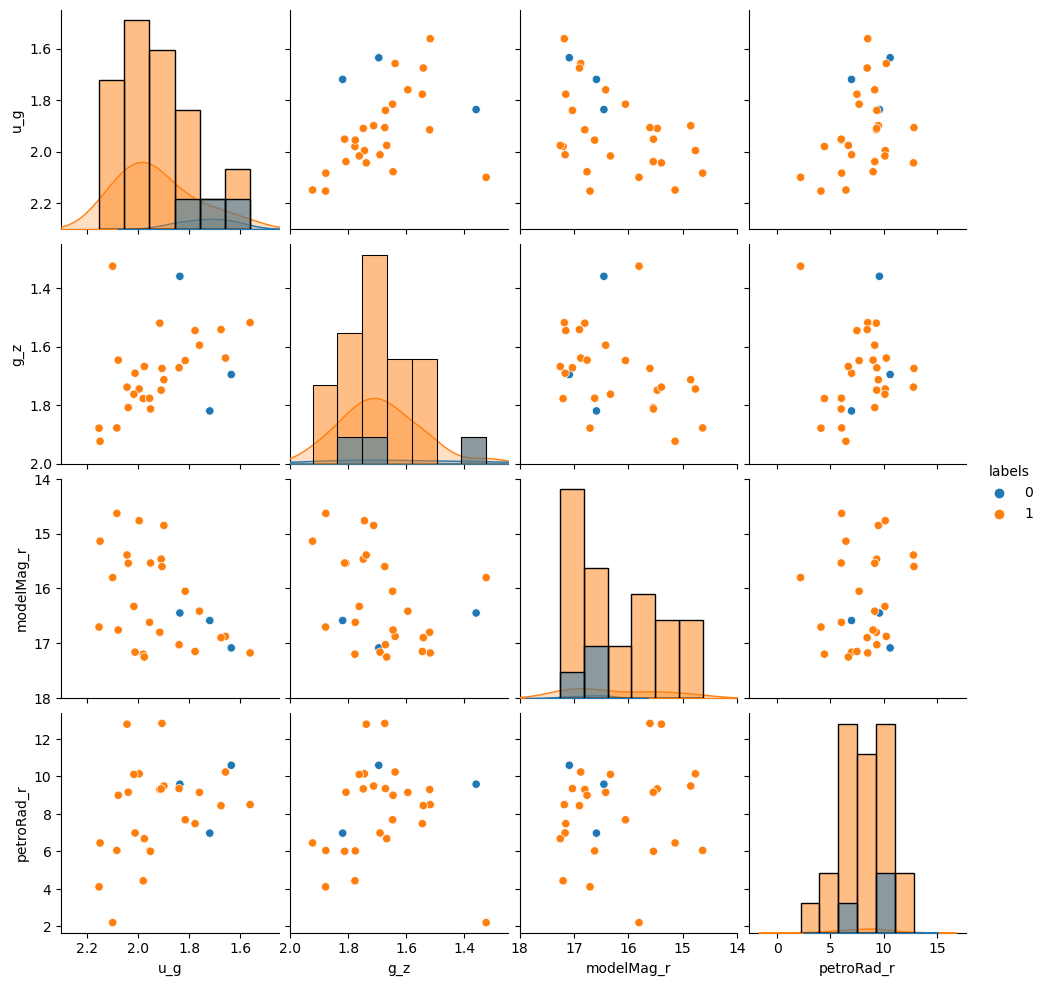

In [12]:
# brightPair = 
p1 = sns.pairplot(pairDf, corner = False, hue = 'labels')
p1.map_diag(sns.histplot)

gz_lim = (1.25, 2.00)
ug_lim = (1.45, 2.30)
modMagr_lim = (14.0, 18.00)

## set column x lims
p1.axes[0, 0].set_xlim(ug_lim[::-1])
p1.axes[0, 1].set_xlim(gz_lim[::-1])
p1.axes[0, 2].set_xlim(modMagr_lim[::-1])

## set row y lims
p1.axes[0, 0].set_ylim(ug_lim[::-1])
p1.axes[1, 0].set_ylim(gz_lim[::-1])
p1.axes[2, 0].set_ylim(modMagr_lim[::-1])

In [13]:
# p2 = sns.pairplot(pairDf, hue = 'labels', corner = True, kind = 'kde')

In [14]:
x1 = pairDf['u_g']
x2 = pairDf['g_z']
# plt.figure()
# plt.plot(x1, x2, 'o')
# plt.xlabel('u_g')
# plt.ylabel('g_z')

(18.0, 14.0)

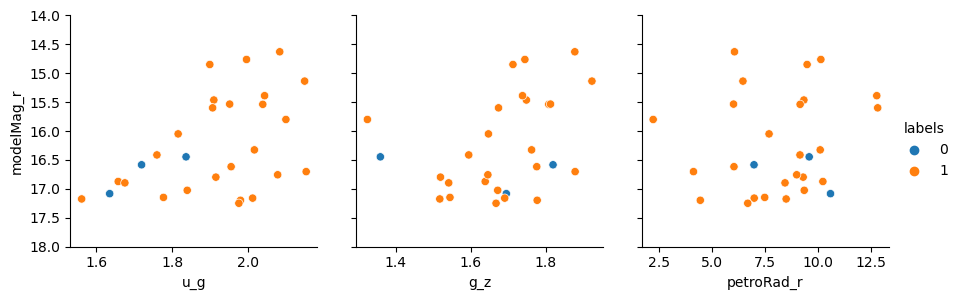

In [15]:
# x_vars = ["u_g", "g_z", "modelMag_r", "petroRad_r"]
x_vars = ["u_g", "g_z", "petroRad_r"]
y_vars = ["modelMag_r"]
g = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.axes[0, 0].set_ylim(modMagr_lim[::-1])


(2.3, 1.45)

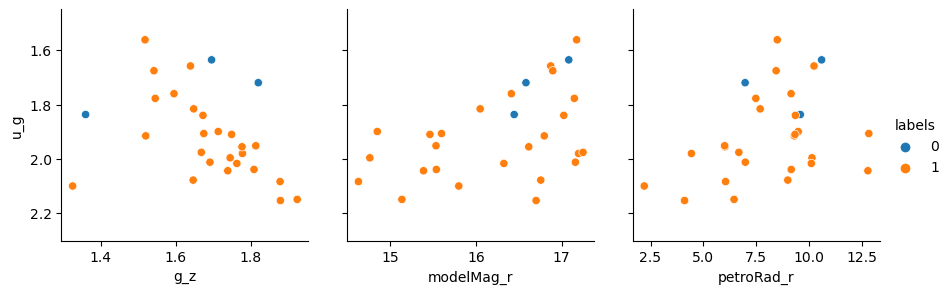

In [16]:
x_vars = ["g_z", "modelMag_r", "petroRad_r"]
y_vars = ["u_g"]
f = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# f.map_diag(sns.histplot, color=".3")
f.map_offdiag(sns.scatterplot)
f.add_legend()
f.axes[0, 0].set_ylim(ug_lim[::-1])


(2.3, 1.45)

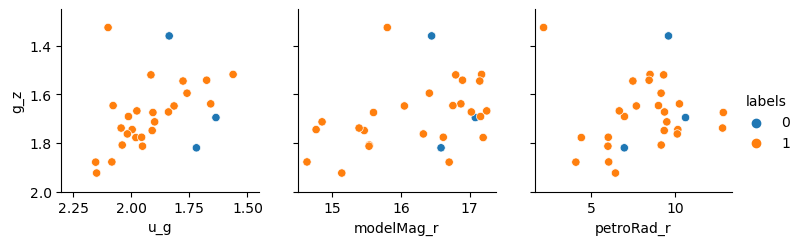

In [17]:
x_vars = ["u_g", "modelMag_r", "petroRad_r"]
y_vars = ["g_z"]
h = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars)
# f.map_diag(sns.histplot, color=".3")
h.map_offdiag(sns.scatterplot)
h.add_legend()
h.axes[0, 0].set_ylim(gz_lim[::-1])
h.axes[0, 0].set_xlim(ug_lim[::-1])


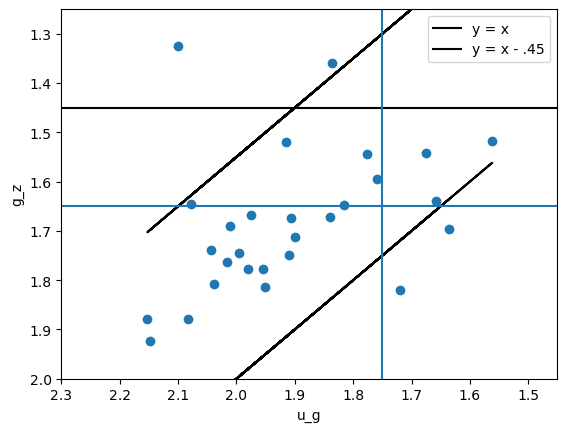

In [18]:
pairDf2 = brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) \
                          & (brightDF1['u_g'] < 1.7) \
                          & (brightDF1['g_z'] < 2.2) \
                          & (brightDF1['g_z'] > 1.6)]

# 1.6 < g_z < 2.2
# u_g > 1.7

x1 = pairDf['u_g']
x2 = pairDf['g_z']
plt.figure()
plt.plot(x1, x2, 'o')
plt.plot(x1, x1, 'k-', label = 'y = x')
plt.plot(x1, x1 - .45, 'k', label =  'y = x - .45')
plt.ylim(gz_lim[::-1])
plt.xlim(ug_lim[::-1])
plt.axhline(y=1.65)
plt.axhline(y=1.45, color = 'k')
plt.axvline(x=1.75)
plt.xlabel('u_g')
plt.ylabel('g_z')
plt.legend()
plt.show()

# Visualizing those bottom right background galaxies:

In [19]:
# 1.6 < g_z < 2.2
# u_g > 1.7

bgBlues = brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) \
                          & (brightDF1['u_g'] < 1.75) \
#                           & (brightDF1['g_z'] < 2.2) \
                          & (brightDF1['g_z'] > 1.65)]

In [20]:
bgBlues

,files,name,labels,reds,objID,ra,dec,type,u_g,modelMag_r,g_z,petroRad_r
16,sdss_ra=49.8832_dec=41.3043.png,PCC-4508,0,9.5525,1237661055281856551,49.883191,41.304234,GALAXY,1.719509,16.58471,1.819835,6.976413
26,sdss_ra=49.5411_dec=41.5389.png,PCC-1795,0,6.0250,1237661055281661552,49.541127,41.538935,GALAXY,1.635536,17.08435,1.695250,10.597430


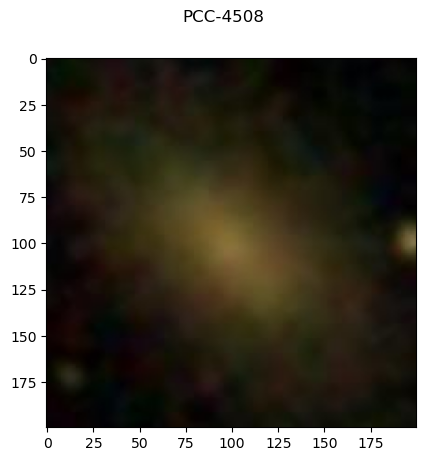

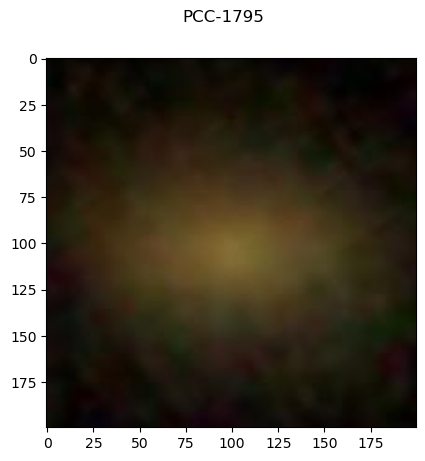

In [21]:
names = bgBlues['name']
names = names.to_list()

for i, x in enumerate(pairDf2['files']):
#     print(i)
    path = os.path.join('SDSS-png', x)
    image = cv2.imread(path)
    image = image[:,:,::-1] ## currently in bgr, needs to be rgb
    plt.imshow(image)
    plt.suptitle(names[i])
    plt.show()

# New SDSS from SQL Query: 
<!-- 
SELECT TOP 20 
    p.objID, p.ra, p.dec, 
    p.modelMag_u-p.modelMag_g as u_g,
    p.modelMag_g-p.modelMag_z as g_z, 
    p.modelMag_r, p.petroRad_r
FROM
    photoObj as p
JOIN dbo.fGetNearbyObjEq(49.9467, 41.5131, 45) as N ON N.objID = p.objID
WHERE
    p.modelMag_u-p.modelMag_g < 1.7
    and p.modelMag_g-p.modelMag_z > p.modelMag_u-p.modelMag_g - .45
    and p.modelMag_g-p.modelMag_z < p.modelMag_u-p.modelMag_g
    and p.modelMag_r < 17.3 -->


In [22]:
dfnew = pd.read_csv('new_set1000.csv')
dfnew

,objID,ra,dec,u_g,g_z,modelMag_r,petroRad_r
0,1.237660e+18,50.351389,41.135867,1.641029,1.556646,16.30981,10.139230
1,1.237660e+18,49.647607,41.667027,1.492852,1.388380,14.44279,2.502188
2,1.237660e+18,49.785213,41.581111,1.675518,1.541508,16.89758,8.444178
3,1.237660e+18,50.216443,41.971605,1.037754,0.641226,14.91491,2.223059
4,1.237660e+18,50.864339,41.710322,0.096003,-0.299940,15.77957,17.284970
5,1.237660e+18,49.334788,41.258372,1.585850,1.395929,16.82821,10.321070
6,1.237660e+18,49.786257,41.126914,1.691584,1.348373,16.78884,15.917080
7,1.237660e+18,48.999980,41.287510,1.310324,0.920393,16.52428,2.525778
8,1.237660e+18,49.904114,41.171023,1.492437,1.232197,17.29912,5.760041
9,1.237670e+18,50.037643,41.817285,1.696735,1.561823,17.12532,16.269340


In [23]:
ra = dfnew['ra']
dec = dfnew['dec']

outDir = 'newSet'
outFiles = glob.glob(os.path.join('.', outDir, '*'))
if len(outFiles) == len(ra):
    print('Skipping populate')
else:
    for i in range(len(ra)):
        urlVar = f'https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/'\
        f'getjpeg?TaskName=Skyserver.Explore.Image&ra={str(ra[i]).strip()}'\
        f'&dec={str(dec[i]).strip()}&scale=0.1&width=200&height=200'

    #     # tell the loop to pause for a bit - every 100 images
    #     if i%100==0:
    #         time.sleep(5)

        img_data = requests.get(urlVar).content
        with open(f'{outDir}/sdss_ra={ra[i]}_dec={dec[i]}.png', 'wb') as handler:
            handler.write(img_data)
            
        # Needs to be assigned after populate
    outFiles = glob.glob(os.path.join('.', outDir, '*'))

In [24]:
# # remove red contaminants
dfnew['files'] = outFiles
redPercent = [0]*len(outFiles)
counter = 0
workDir = outDir

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(outFiles):
    testImgPath = x
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]
#     print(f'{filename}, {subtitle_string}')
#     if percent > 50.0:
#         counter += 1
# #         print('To be removed')
#     else:
#         pass

dfnew['redPercent'] = redPercent # add new column of the red percentage of an image
redList = (dfnew['redPercent'] >= 50) # percentage threshold of how much red is in the image
dfnew_filtered = dfnew[dfnew['redPercent'] <= 50]
# dfnew_filtered.shape

redInds = np.where(redList)[0] # the indices of the hot pixel images to be removed
print(f'{len(redInds)} of the images are over 50 percent red')
print(f'{len(redInds)/len(outFiles)*100:.2f} % of images are over 50 percent red')
# for n in redInds:
#     imStr = dfnew['files'].to_list()[n]
# #     imStr = outDir + red
#     im = cv2.imread(imStr)[:,:,::-1] # [:,:,::-1] switches rgb to bgr and vice versa
#     plt.figure
#     plt.imshow(im)
#     plt.show()


4 of the images are over 50 percent red
12.12 % of images are over 50 percent red


In [25]:
dfnew_filtered

,objID,ra,dec,u_g,g_z,modelMag_r,petroRad_r,files,redPercent
0,1.237660e+18,50.351389,41.135867,1.641029,1.556646,16.30981,10.139230,.\newSet\sdss_ra=48.99997953_dec=41.28751027.png,0.7050
1,1.237660e+18,49.647607,41.667027,1.492852,1.388380,14.44279,2.502188,.\newSet\sdss_ra=49.23853032_dec=41.35674474.png,38.2050
2,1.237660e+18,49.785213,41.581111,1.675518,1.541508,16.89758,8.444178,.\newSet\sdss_ra=49.30302653_dec=41.48337941.png,47.3050
3,1.237660e+18,50.216443,41.971605,1.037754,0.641226,14.91491,2.223059,.\newSet\sdss_ra=49.33478789_dec=41.25837194.png,9.5200
4,1.237660e+18,50.864339,41.710322,0.096003,-0.299940,15.77957,17.284970,.\newSet\sdss_ra=49.4104878_dec=41.01142476.png,0.4075
5,1.237660e+18,49.334788,41.258372,1.585850,1.395929,16.82821,10.321070,.\newSet\sdss_ra=49.51836975_dec=41.36974302.png,5.7350
6,1.237660e+18,49.786257,41.126914,1.691584,1.348373,16.78884,15.917080,.\newSet\sdss_ra=49.64760695_dec=41.66702696.png,7.0825
7,1.237660e+18,48.999980,41.287510,1.310324,0.920393,16.52428,2.525778,.\newSet\sdss_ra=49.67044705_dec=41.73750276.png,15.4050
8,1.237660e+18,49.904114,41.171023,1.492437,1.232197,17.29912,5.760041,.\newSet\sdss_ra=49.693181_dec=41.03112697.png,0.1575
9,1.237670e+18,50.037643,41.817285,1.696735,1.561823,17.12532,16.269340,.\newSet\sdss_ra=49.70929763_dec=42.15148229.png,49.8600
